# **딥러닝 모델 훈련 및 추론**

## **1. 드라이브 연결**

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2. 파라미터 설정, 데이터 로드, 데이터셋 분리**

- 데이터 전처리: MinMax Scaler
- 데이터 증강: Sliding Window

In [ ]:
# ==========================================
# 1. 라이브러리 및 환경 설정
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import os
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 2. 통합 데이터 전처리 (Unified Dataset)
# ==========================================
file_path = "/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx"
if os.path.exists(file_path):
    df = pd.read_excel(file_path) if file_path.endswith('.xlsx') else pd.read_csv(file_path)
else:
    df = pd.DataFrame()

sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

def create_sequences_with_ids(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):
    data_values = df_target[sensor_cols].values
    if is_train:
        if scaler is None: scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        data_scaled = scaler.transform(data_values)

    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences, all_wafer_ids = [], []
    for wafer in df_scaled[wafer_col].unique():
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values
        if len(wafer_data) < seq_len: continue
        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])
            all_wafer_ids.append(wafer)

    if len(all_sequences) == 0: return np.array([]), np.array([]), scaler
    return np.array(all_sequences), np.array(all_wafer_ids), scaler



# --- 데이터 통합 및 분할 ---
datasets = {}
target_experiments = ['l29', 'l31', 'l33']
SEQ_LEN = 32
TRAIN_RATIO = 0.7

print(f"🚀 Creating Unified Dataset from: {target_experiments}")

# 통합 데이터 필터링
combined_mask = df['Wafer_ID'].str.contains('|'.join(target_experiments), case=False, na=False)
combined_df = df[combined_mask]

# ID 셔플 및 분할
all_normal_ids = combined_df[combined_df['Label'] == 'Normal']['Wafer_ID'].unique()
all_fault_ids = combined_df[combined_df['Label'] == 'Fault']['Wafer_ID'].unique()

np.random.seed(42)
np.random.shuffle(all_normal_ids)

n_train = int(len(all_normal_ids) * TRAIN_RATIO)
train_ids = all_normal_ids[:n_train]
test_norm_ids = all_normal_ids[n_train:]

# 데이터프레임 분할
df_train = combined_df[combined_df['Wafer_ID'].isin(train_ids)]
df_test_norm = combined_df[combined_df['Wafer_ID'].isin(test_norm_ids)]
df_test_fault = combined_df[combined_df['Wafer_ID'].isin(all_fault_ids)]

# 시퀀스 생성
X_train, ids_train, global_scaler = create_sequences_with_ids(df_train, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True)
X_test_norm, ids_test_norm, _ = create_sequences_with_ids(df_test_norm, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=global_scaler, is_train=False)
X_test_fault, ids_test_fault, _ = create_sequences_with_ids(df_test_fault, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=global_scaler, is_train=False)

# 사용자가 제공한 get_data_loaders 함수가 작동하도록 딕셔너리에 저장
datasets['Unified'] = {
    'X_train': X_train,
    'X_test_norm': X_test_norm,
    'ids_test_norm': ids_test_norm,
    'X_test_fault': X_test_fault,
    'ids_test_fault': ids_test_fault
}
print("✅ Unified Dataset Prepared.")

Using device: cuda
🚀 Creating Unified Dataset from: ['l29', 'l31', 'l33']
✅ Unified Dataset Prepared.


## **3. 함수 설정**

In [ ]:
def get_data_loaders(exp_id, datasets_dict, batch_size=32):
    print(f"\n📊 [Data Setup] Experiment: {exp_id}")
    data = datasets_dict[exp_id]

    # 데이터 추출
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    ids_test_norm = data['ids_test_norm']
    X_test_fault = data['X_test_fault']
    ids_test_fault = data['ids_test_fault']

    # Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # DataLoader (Train only)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    return train_loader, (test_norm_tensor, ids_test_norm), (test_fault_tensor, ids_test_fault)

def aggregate_wafer_scores(window_scores, wafer_ids, method='max'):
    # DataFrame핑하여 GroupBy 연산
    df_temp = pd.DataFrame({'Wafer_ID': wafer_ids, 'Score': window_scores})

    if method == 'max':
        grouped = df_temp.groupby('Wafer_ID')['Score'].max()
    else:
        grouped = df_temp.groupby('Wafer_ID')['Score'].mean()

    return grouped.index.values, grouped.values

def visualize_results(model_name, exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance (Wafer-Level)", fontsize=16, fontweight='bold')

    # Confusion Matrix
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    axes[0].set_title("Confusion Matrix")

    # Scatter Plot (Wafer Scores)
    normal_idx = np.where(labels == 0)[0]
    fault_idx = np.where(labels == 1)[0]

    axes[1].scatter(normal_idx, scores[normal_idx], color='blue', label='Normal', alpha=0.6, s=20)
    axes[1].scatter(fault_idx, scores[fault_idx], color='red', label='Fault', alpha=0.6, s=20)
    axes[1].axhline(y=threshold, color='green', linestyle='--', label='Threshold')
    axes[1].set_title("Wafer Anomaly Scores")
    axes[1].legend()

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[2].set_title("ROC Curve")
    axes[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def evaluate_performance(model_name, exp_id, scores, labels):
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Wafer-Level Summary")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1

In [ ]:
# ==========================================
# 3. 모델 정의 (TRACE-GPT Fixed Version)
# ==========================================
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation)
    def forward(self, x):
        return self.conv(x)[:, :, :-self.padding]

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            layers += [CausalConv1d(in_channels, num_channels[i], kernel_size, dilation=dilation_size), nn.ReLU(), nn.Dropout(dropout)]
        self.network = nn.Sequential(*layers)
    def forward(self, x): return self.network(x)

class TRACE_GPT(nn.Module):
    def __init__(self, num_sensors, seq_len, d_model=64, n_head=8, num_layers=6, resolution=100, dropout=0.1):
        super(TRACE_GPT, self).__init__()
        self.num_sensors = num_sensors
        self.seq_len = seq_len
        self.resolution = resolution
        self.d_model = d_model

        self.tcn = TemporalConvNet(num_sensors + 1, [d_model] * 4, kernel_size=3, dropout=dropout)
        self.transformer = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, nhead=n_head, batch_first=True, dropout=dropout), num_layers=num_layers
        )
        self.head = nn.Linear(d_model, num_sensors * resolution)

    def forward(self, x):
        B, L, _ = x.size()
        time_idx = (torch.arange(L, device=x.device).float() / self.seq_len).view(1, L, 1).expand(B, -1, -1)
        x_emb = torch.cat([x, time_idx], dim=2)
        x_tcn = self.tcn(x_emb.permute(0, 2, 1)).permute(0, 2, 1)
        mask = torch.triu(torch.ones(L, L, device=x.device) * float('-inf'), diagonal=1)
        out = self.transformer(x_tcn, x_tcn, tgt_mask=mask)
        return self.head(out).view(B, L, self.num_sensors, self.resolution)

# ==========================================
# 4. 학습 및 평가 함수
# ==========================================
def quantize(x, res=100): return torch.clamp((x * (res - 1)).long(), 0, res - 1)

def train_epoch(model, loader, opt, device, res=100):
    model.train()
    loss_sum = 0
    criterion = nn.CrossEntropyLoss()
    for (x,) in loader:
        x = x.to(device)
        input_seq, target_seq = x[:, :-1], x[:, 1:]
        out = model(input_seq)
        loss = criterion(out.reshape(-1, res), quantize(target_seq, res).reshape(-1))
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item()
    return loss_sum / len(loader)

def get_window_scores(model, x_tensor, device, res=100):
    model.eval()
    scores = []
    criterion = nn.CrossEntropyLoss(reduction='none')
    loader = DataLoader(TensorDataset(x_tensor), batch_size=32, shuffle=False)
    with torch.no_grad():
        for (x,) in loader:
            x = x.to(device)
            input_seq, target_seq = x[:, :-1], x[:, 1:]
            out = model(input_seq)
            loss = criterion(out.reshape(-1, res), quantize(target_seq, res).reshape(-1))
            scores.extend(loss.view(input_seq.shape[:3]).mean(dim=[1, 2]).cpu().numpy())
    return np.array(scores)

def aggregate_scores(w_scores, w_ids):
    df = pd.DataFrame({'id': w_ids, 'score': w_scores})
    return df.groupby('id')['score'].max().values, df.groupby('id')['score'].max().index.values


# **모델 구현 및 추론**


📊 [Data Setup] Experiment: Unified

🔥 Starting Training on Unified Dataset...
Epoch 2: Loss 2.3308
Epoch 4: Loss 2.1301
Epoch 6: Loss 2.0750
Epoch 8: Loss 2.0412
Epoch 10: Loss 2.0143

🔍 Running Inference...
Aggregating Wafer Scores...

📌 [Unified TRACE-GPT - Combined_Experiments] Wafer-Level Summary
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 2.590684


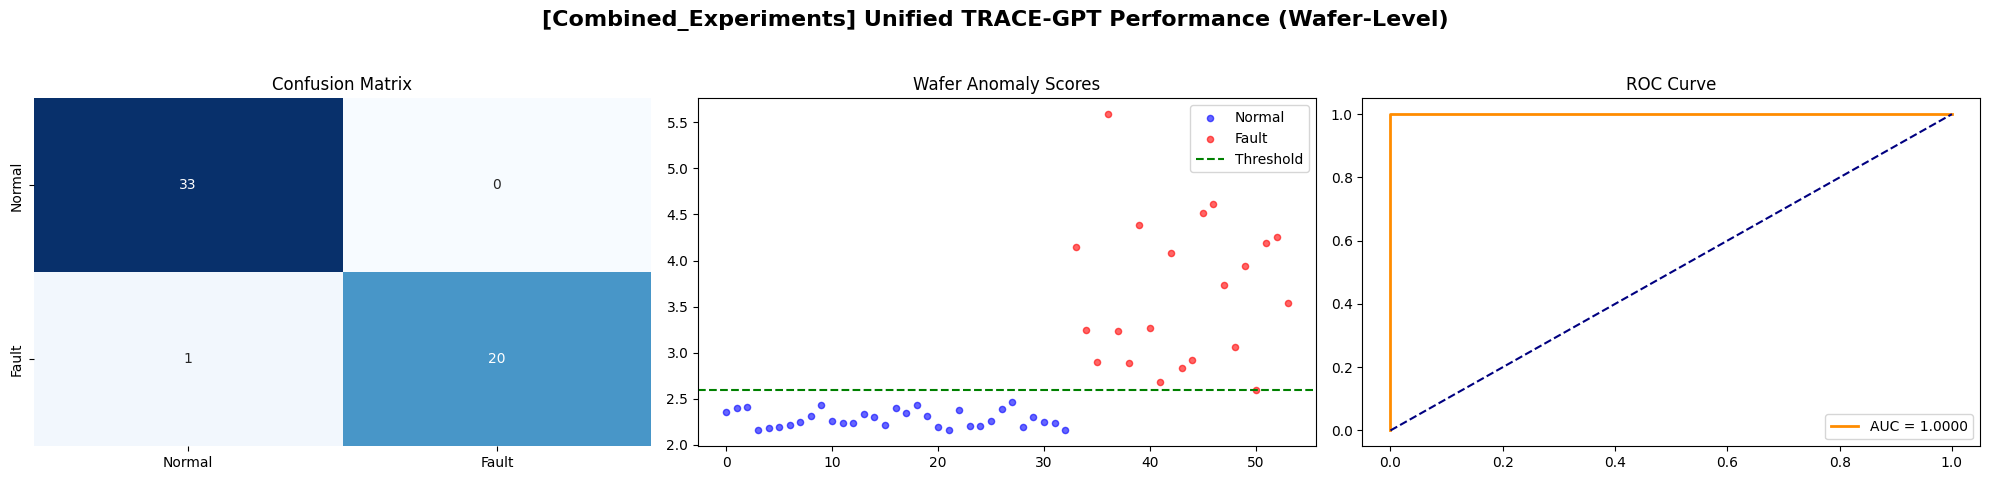

(np.float64(1.0), np.float64(1.0))

In [ ]:
# ==========================================
# 4. 학습 및 실행 (Unified Model)
# ==========================================
def quantize(x, res=100): return torch.clamp((x * (res - 1)).long(), 0, res - 1)

def train_epoch(model, loader, opt, device, res=100):
    model.train()
    loss_sum = 0
    criterion = nn.CrossEntropyLoss()
    for (x,) in loader:
        x = x.to(device)
        input_seq, target_seq = x[:, :-1], x[:, 1:]
        out = model(input_seq)
        loss = criterion(out.reshape(-1, res), quantize(target_seq, res).reshape(-1))
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item()
    return loss_sum / len(loader)

def get_window_scores(model, x_tensor, device, res=100):
    model.eval()
    scores = []
    criterion = nn.CrossEntropyLoss(reduction='none')
    loader = DataLoader(TensorDataset(x_tensor), batch_size=32, shuffle=False)
    with torch.no_grad():
        for (x,) in loader:
            x = x.to(device)
            input_seq, target_seq = x[:, :-1], x[:, 1:]
            out = model(input_seq)
            loss = criterion(out.reshape(-1, res), quantize(target_seq, res).reshape(-1))
            scores.extend(loss.view(input_seq.shape[:3]).mean(dim=[1, 2]).cpu().numpy())
    return np.array(scores)

# --- Main Execution ---
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001

# 1. 통합 데이터 로드 (Unified 키 사용)
# 사용자 제공 함수 get_data_loaders 활용
train_loader, (test_norm, ids_norm), (test_fault, ids_fault) = get_data_loaders('Unified', datasets, BATCH_SIZE)

# 2. 모델 초기화
model = TRACE_GPT(num_sensors=X_train.shape[2], seq_len=SEQ_LEN-1).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

# 3. 학습
print(f"\n🔥 Starting Training on Unified Dataset...")
for ep in range(EPOCHS):
    loss = train_epoch(model, train_loader, optimizer, device)
    if (ep+1) % 2 == 0:
        print(f"Epoch {ep+1}: Loss {loss:.4f}")

# 4. 추론 (Window Scores)
print("\n🔍 Running Inference...")
norm_w_scores = get_window_scores(model, test_norm, device)
fault_w_scores = get_window_scores(model, test_fault, device)

# 5. 집계 (Wafer Scores) - 사용자 제공 함수 aggregate_wafer_scores 활용
print("Aggregating Wafer Scores...")
_, norm_wafer_scores = aggregate_wafer_scores(norm_w_scores, ids_norm, method='max')
norm_labels = np.zeros(len(norm_wafer_scores))

_, fault_wafer_scores = aggregate_wafer_scores(fault_w_scores, ids_fault, method='max')
fault_labels = np.ones(len(fault_wafer_scores))

final_scores = np.concatenate([norm_wafer_scores, fault_wafer_scores])
final_labels = np.concatenate([norm_labels, fault_labels])

# 6. 평가 및 시각화 - 사용자 제공 함수 evaluate_performance 활용
# 이 함수가 내부적으로 visualize_results를 호출하여 산점도(Scatter Plot)를 그립니다.
evaluate_performance("Unified TRACE-GPT", "Combined_Experiments", final_scores, final_labels)